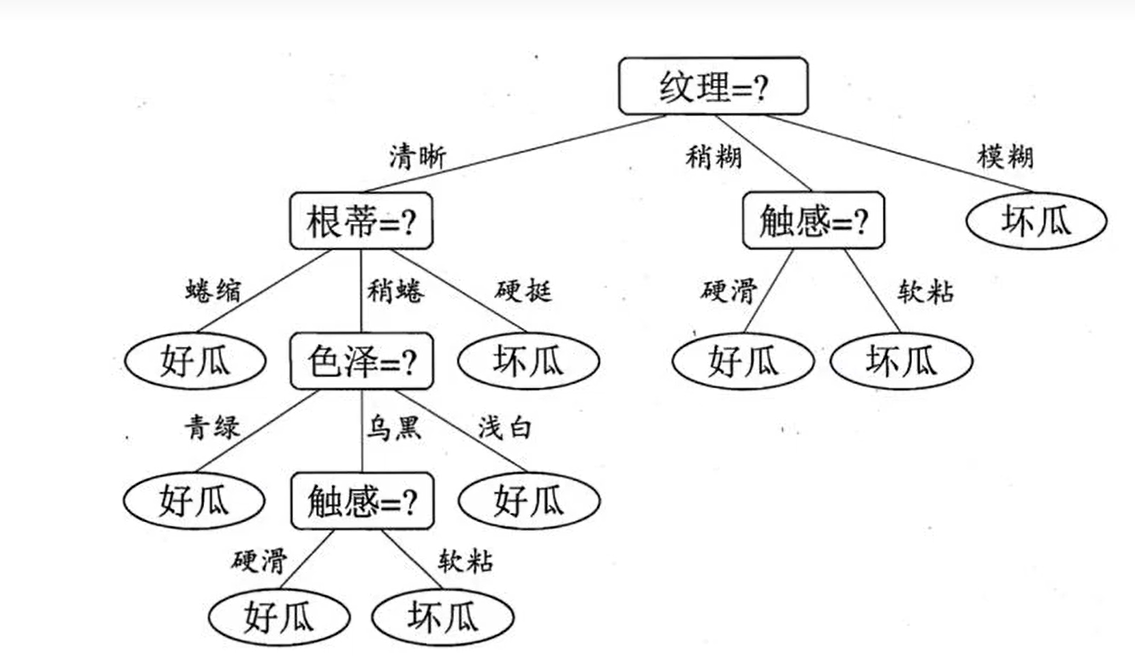

# P63 例5.2 信息增益生成决策树 （使用5.1数据集）

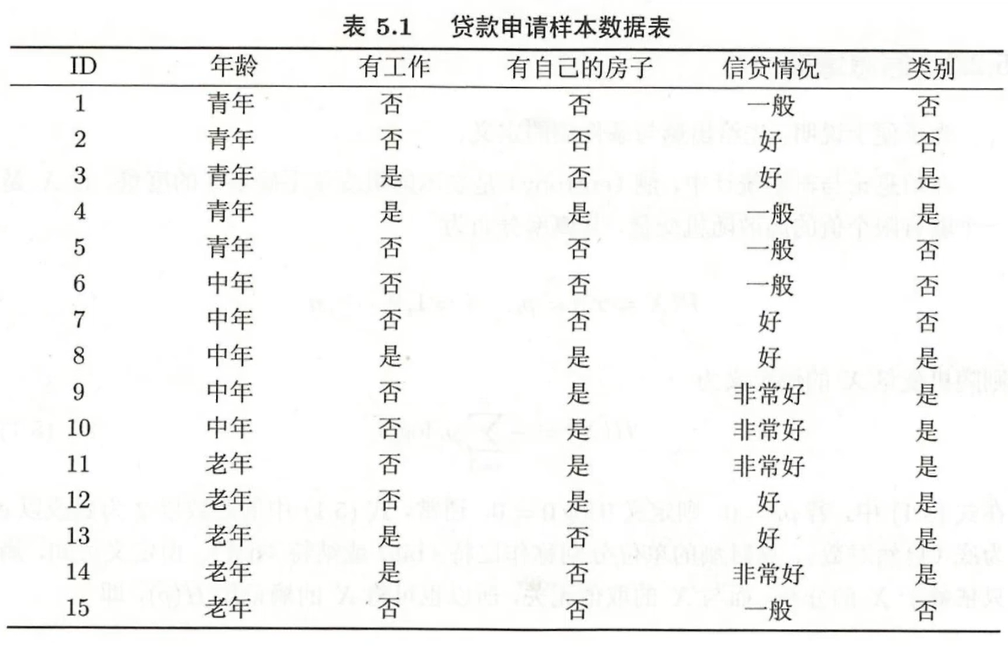

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from collections import Counter
import math
from math import log

import pprint

# 书上题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

datasets, labels = create_data()

# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
    return ent

# 经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p)/data_length)*calc_ent(p) for p in feature_sets.values()])
    return cond_ent


# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent


def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

print(info_gain_train(np.array(datasets)))


特征(年龄) - info_gain - 0.083
特征(有工作) - info_gain - 0.324
特征(有自己的房子) - info_gain - 0.420
特征(信贷情况) - info_gain - 0.363
特征(有自己的房子)的信息增益最大，选择为根节点特征


# P65 例5.3 ID3算法建立决策树

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from math import log
import pprint
# 书上题目5.1
def create_data():
    datasets = [['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels
#ID算法生成决策树
# 定义节点类 二叉树
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}
    def __repr__(self):
        return '{}'.format(self.result)
    def add_node(self, val, node):
        self.tree[val] = node
    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
class DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}
    # 熵
    @staticmethod
    def calc_ent(datasets):
        data_length = len(datasets)
        label_count = {}
        for i in range(data_length):
            label = datasets[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p / data_length) * log(p / data_length, 2) for p in label_count.values()])
        return ent
    # 经验条件熵
    def cond_ent(self, datasets, axis=0):
        data_length = len(datasets)
        feature_sets = {}
        for i in range(data_length):
            feature = datasets[i][axis]
            if feature not in feature_sets:
                feature_sets[feature] = []
            feature_sets[feature].append(datasets[i])
        cond_ent = sum([(len(p) / data_length) * self.calc_ent(p) for p in feature_sets.values()])
        return cond_ent
    # 信息增益
    @staticmethod
    def info_gain(ent, cond_ent):
        return ent - cond_ent
    def info_gain_train(self, datasets):
        count = len(datasets[0]) - 1
        ent = self.calc_ent(datasets)
        best_feature = []
        for c in range(count):
            c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
            best_feature.append((c, c_info_gain))
        # 比较大小
        best_ = max(best_feature, key=lambda x: x[-1])
        return best_
    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        _, y_train, features = train_data.iloc[:, :-1], train_data.iloc[:, -1], train_data.columns[:-1]
        # 1,若D中实例属于同一类Ck，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_train.value_counts()) == 1:
            return Node(root=True,
                        label=y_train.iloc[0])
        # 2, 若A为空，则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])
        # 3,计算最大信息增益 同5.1,Ag为信息增益最大的特征
        max_feature, max_info_gain = self.info_gain_train(np.array(train_data))
        max_feature_name = features[max_feature]
        # 4,Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是实例数最大的类Ck作为该节点的类标记，返回T
        if max_info_gain < self.epsilon:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])
        # 5,构建Ag子集
        node_tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)
        feature_list = train_data[max_feature_name].value_counts().index
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)
            # 6, 递归生成树
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
        # pprint.pprint(node_tree.tree)
        return node_tree
    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree
    def predict(self, X_test):
        return self._tree.predict(X_test)
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DTree()
tree = dt.fit(data_df)
print(dt.predict(['老年', '否', '否', '一般']))


否


# C4.5构建决策树

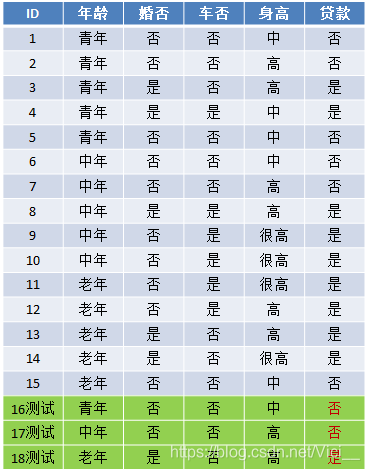

In [22]:
import math 
import random
import numpy as np
from math import log
import operator

'''
1. 获取数据集
'''
def get_dataset():
    dataset = [['青年', '否', '否', '中', '否'],
                ['青年', '否', '否', '高', '否'],
                ['青年', '是', '否', '高', '是'],
                ['青年', '是', '是', '中', '是'],
                ['青年', '否', '否', '中', '否'],
                ['中年', '否', '否', '中', '否'],
                ['中年', '否', '否', '高', '否'],
                ['中年', '是', '是', '高', '是'],
                ['中年', '否', '是', '很高', '是'],
                ['中年', '否', '是', '很高', '是'],
                ['老年', '否', '是', '很高', '是'],
                ['老年', '否', '是', '高', '是'],
                ['老年', '是', '否', '高', '是'],
                ['老年', '是', '否', '很高', '是'],
                ['老年', '否', '否', '中', '否']]
    test_dataset = [['青年', '否', '否', '中'],
                    ['中年', '否', '否', '高'],
                    ['老年', '是', '否', '高']]
    labels = ['年龄', '婚否', '车否', '身高'] # 特征名称
    class_label = '贷款'
    return dataset, labels, class_label, test_dataset

'''
2. 计算信息熵
'''
def calc_shannonent(dataset):
    n = len(dataset) # 数据集长度
    shannonent = 0.0 # 初始化信息熵
    label_counts = {} # 标签与个数的映射， 形式：{'是':9, '否':6}
    # 遍历数据集，找到所有的标签，以及属于此标签的行数
    for data in dataset:
        label = data[-1] # 每行最后一列的值为标签
        if label not in label_counts: # 如果此标签未出现过
            label_counts[label] = 1 # 计数初始化为1
        else:
            label_counts[label] += 1 # 否则加1
    # 计算数据集D的信息熵，sum(-p*log2(p))
    for key in label_counts: 
        p = float(label_counts[key] / n) # 计算概率，属于此标签的数据占总数据的比例
        shannonent -= p * log(p, 2) # 计算信息熵
    return shannonent
'''
3. 分割数据集
'''
def split_dataset(dataset, axis, value): # axis是列号，value是值
    result = []
    for data in dataset:
        if data[axis] == value: # 如果该行数据axis列的值为value
            r = data[:axis] + data[axis+1:] # 就把这一行除axis列以外的元素放入r
            result.append(r)                # 意思就是，当前是以axis列的特征作为决策树分支标准的，
    return result                           # 那么再继续往下进行时，就要以除此特征之外的其它特征为标准分类

'''
4. 获取最佳特征，计算信息增益率，并比较
'''
def choose_best_feature(dataset):
    numFeatures = len(dataset[0]) - 1 # 特征个数，除去最后一列的分类标签
    ent = calc_shannonent(dataset) # 当前数据集的信息熵
    best_gain = 0.0 # 最佳信息熵
    best_feature_id = -1 # 最佳信息熵的特征编号
    infogain = 0.0 # 最佳信息增益率
    for i in range(numFeatures):
        unique_values = set([line[i] for line in dataset]) # 获取数据集中当前特征的所有值
        new_ent = 0.0
        s = 0.0
        for value in unique_values: # 遍历此特征所有的值
            sub_dataset = split_dataset(dataset, i, value) # 按照这个值，获得子数据集 
            prob = len(sub_dataset) / len(dataset) # 子数据集的长度 就是 此特征i值为value时的数据个数
            new_ent += prob * calc_shannonent(sub_dataset)  # 例：𝑔(𝑍|𝐴)
            s -= prob * log(prob, 2) # 例：𝑆𝑝𝑙𝑖𝑡𝐼𝑛𝑓𝑜𝑟_𝐴 (𝑍)
        gain = ent - new_ent # 计算信息增益
        infogain = gain / s # 计算信息增益率
        if infogain > best_gain: # 如果此信息增益率更大
            best_gain = infogain # 更新
            best_feature_id = i
    return best_feature_id # 返回信息增益率更大的特征编号

'''
5. 创建决策树，算法主函数（以第一次分支为例）
'''
def createTree(dataset, labels):
    class_list = [data[-1] for data in dataset]  # 获取当前数据集每行的分类标签，贷款是/否
    if class_list.count(class_list[0]) == len(class_list):
        # 如果当前数据集中，属于同一类，则退出递归
        return class_list[0] # 返回此类的标签

    # 获取最好的分类特征索引
    best_feature_id = choose_best_feature(dataset) # 编号为2
    # 获取该特征的名字
    best_feature_label = labels[best_feature_id] # 特征名为：车否

    # 这里直接使用字典变量来存储树信息，这对于回执树形图很重要
    my_tree = {best_feature_label:{}}    # 当前数据集选取最好的特征存储在bestFeat中
    del(labels[best_feature_id])    # 删除已经在选取的特征  此时  labels = ['是否有车']
    
    # 取出最优列的值
    feature_values_set = set([data[best_feature_id] for data in dataset]) # ['是', '否']
    for value in feature_values_set: # 对于此特征的每一个取值
        subLabels = labels[:]       #copy all of labels, so trees don't mess up existing labels
        temp = split_dataset(dataset, best_feature_id, value) # 切分数据集，进行分支
        my_tree[best_feature_label][value] = createTree(temp, subLabels) # 对于每一个子节点递归建树
    return my_tree
'''
6. 输入特征，进行预测
'''
# 决策树算法得到的结果是这种形式的：{'车否': {'否': {'婚否': {'否': '否', '是': '是'}}, '是': '是'}}
def get_class(node, data, step=0): # 递归函数
    if type(node) == str: # 如果当前结点类型为str，而不是dict，说明找到结果了
        return node # 返回结果
    for k1, v1 in node.items(): # 找到特征名称
        for k2, v2 in v1.items(): # 找到决策树中此特征的取值
            if data[k1] == k2: # 如果当前数据中此特征的值等于k2
                res = get_class(v2, data, step+1) # 递归
                if res != None: # 如果找到的结果不是None，则一定是“是”或“否”
                    return res # 直接返回
# 预测主函数
def predict(test_dataset, my_tree, labels):
    print("使用决策树预测：")
    for i in range(len(test_dataset)): # 遍历测试集
        data = {} # 将测试集的每一行数据，做个特征到特征值的映射
        for j in range(len(test_dataset[i])):
            data[labels[j]] = test_dataset[i][j]
        res = get_class(my_tree, data) # 根据决策树，找到结果
        print(test_dataset[i], res) # 打印结果

'''
7. 打印树
'''
def show_result(node, class_label, step=0):
    if type(node) == str:
        print('-'*step + class_label + "：" + node)
        return
    for k1, v1 in node.items():
        for k2, v2 in v1.items():
            print('-'*step + k1 + ':' + k2)
            show_result(v2, class_label, step+1)

dataset, labels, class_label, test_dataset = get_dataset()
tmp_labels = labels[:]
my_tree = createTree(dataset, tmp_labels)
print("打印决策树：")
show_result(my_tree, class_label)
print("---------------------------------")
predict(test_dataset, my_tree, labels)


打印决策树：
车否:是
-贷款：是
车否:否
-婚否:是
--贷款：是
-婚否:否
--贷款：否
---------------------------------
使用决策树预测：
['青年', '否', '否', '中'] 否
['中年', '否', '否', '高'] 否
['老年', '是', '否', '高'] 是


# Cart_classfication

In [4]:
# --*-- coding:utf-8 --*--
import numpy as np

class Node: #结点
    def __init__(self, data = None, lchild = None, rchild = None):
        self.data = data
        self.child = {} #需要用字典的key来做边的值('是'，'否')

class DecisionTree4Cart:    #分类与回归树
    def create(self, dataSet, labels):
        featureSet = self.createFeatureSet(dataSet)
        def createBranch(dataSet, featureSet):
            classLabel = [row[-1] for row in dataSet]    #按列读取标签
            node = Node()
            if (len(set(classLabel)) == 1):   #说明已经没有需要划分的了
                node.data = classLabel[0]
                node.child = None
                return node
            minGini = 1.1    #    #不会超过1
            minGiniIndex = -1
            minGiniFeature = None
            for key in featureSet:
                feature = featureSet[key]
                for x in feature:
                    gini = self.calcConditionalGini(dataSet, key, x) #计算基尼指数
                    print(gini)
                    if (minGini > gini):    #比较得出最小的基尼指数
                        minGini = gini
                        minGiniIndex = key
                        minGiniFeature = x
            node.data = labels[minGiniIndex]
            subFeatureSet = featureSet.copy()
            del subFeatureSet[minGiniIndex]#删除特征集（不再作为划分依据）
            subDataSet1 = [row for row in dataSet if row[minGiniIndex] == minGiniFeature]
            node.child[minGiniFeature] = createBranch(subDataSet1, subFeatureSet)
            subDataSet2 = [row for row in dataSet if row[minGiniIndex] != minGiniFeature]
            node.child["other"] = createBranch(subDataSet2, subFeatureSet)
            return node
        return createBranch(dataSet, featureSet)

    def calcConditionalGini(self, dataSet, featureIndex, value):   #计算基尼指数
        conditionalGini = 0
        """
        可以看出下面的代码使按公式5.25来的吗？
        """
        subDataSet1 = [row for row in dataSet if row[featureIndex] == value]    #按值划分数据集，这是第一个数据集
        conditionalGini += len(subDataSet1) / float(len(dataSet)) * self.calcGini(subDataSet1)
        subDataSet2 = [row for row in dataSet if row[featureIndex] != value]    #第二个数据集
        conditionalGini += len(subDataSet2) / float(len(dataSet)) * self.calcGini(subDataSet2)
        return conditionalGini

    def calcGini(self, dataSet, featureKey = -1):   #计算基尼指数
        classLabel = [row[featureKey] for row in dataSet]
        labelSet = set(classLabel)  #类别的集合
        gini = 1
        for x in labelSet:  #此为遍历类标签的类别，计算熵
            gini -= ((classLabel.count(x) / float(len(dataSet))) ** 2) #按公式5.24来
        return gini

    def preOrder(self, node, depth = 0):    #先序遍历
        if (node != None):
            print(node.data, depth)
            if (node.child != None):
                for key in node.child:
                    print(key)
                    self.preOrder(node.child[key], depth + 1)

    def createFeatureSet(self, dataSet):    #创建特征集
        featureSet = {}
        m, n = np.shape(dataSet)
        for i in range(n - 1):  #按列来遍历,n-1代表不存入类别的特征
            column = list(set([row[i] for row in dataSet]))    #按列提取数据
            featureSet[i] = column   #每一行就是每一维的特征值
        return featureSet

    def classify(self, node, labels, testVec):  #类别判断
        while node != None:
            if (node.data in labels):   #用来判断是否内部结点，内部结点就继续往下找
                index = labels.index(node.data) #非根结点意味着是根据某个特征划分的，找出该特征的索引
                x = testVec[index]
                for key in node.child:  #遍历结点孩子字典，用key来做权值来判断该往左结点移动还是右节点
                    if x == key:
                        node = node.child[key]
                        break
                else:
                    node = node.child['other']
            else:
                break
        return node.data
if __name__ == '__main__':
    dataSet = [['青年', '否', '否', '一般', '否'],
           ['青年', '否', '否', '好', '否'],
           ['青年', '是', '否', '好', '是'],
           ['青年', '是', '是', '一般', '是'],
           ['青年', '否', '否', '一般', '否'],
           ['中年', '否', '否', '一般', '否'],
           ['中年', '否', '否', '好', '否'],
           ['中年', '是', '是', '好', '是'],
           ['中年', '否', '是', '非常好', '是'],
           ['中年', '否', '是', '非常好', '是'],
           ['老年', '否', '是', '非常好', '是'],
           ['老年', '否', '是', '好', '是'],
           ['老年', '是', '否', '好', '是'],
           ['老年', '是', '否', '非常好', '是'],
           ['老年', '否', '否', '一般', '否']]
    labels = ['年龄', '有工作', '有自己的房子', '信贷情况']
    tree = DecisionTree4Cart()
    node = tree.create(dataSet, labels)
    tree.preOrder(node)
    for dataLine in dataSet:
        print(tree.classify(node, labels, dataLine))

0.44
0.43999999999999995
0.4799999999999999
0.31999999999999995
0.31999999999999995
0.26666666666666666
0.26666666666666666
0.4740740740740741
0.31999999999999984
0.36363636363636365
0.43333333333333335
0.33333333333333326
0.380952380952381
0.0
0.0
0.3999999999999999
0.26666666666666666
0.3333333333333333
有自己的房子 0
是
是 1
other
有工作 1
是
是 2
other
否 2
否
否
是
是
否
否
否
是
是
是
是
是
是
是
否


# Cart_regression

In [6]:
# --*-- coding:utf-8 --*--
import numpy as np

class RegressionTree:   #回归树
    def loadDataSet(self, fileName):    #加载数据
        dataMat = []
        fr = open(fileName)
        for line in fr.readlines(): #遍历每一行
            curLine = line.strip().split('\t')
            fltLine = list(map(float, curLine))   #将里面的值映射成float,否则是字符串类型的
            dataMat.append(fltLine)
        return dataMat

    def binSplitDataSet(self, dataSet, feature, value): #按某列的特征值来划分数据集
        mat0 = dataSet[np.nonzero(dataSet[:, feature] > value)[0], :]   #勘误：这里跟书上不一样，需修改
        mat1 = dataSet[np.nonzero(dataSet[:, feature] <= value)[0], :]  #np.nonzero(...)[0]返回一个列表
        return mat0, mat1
    def regLeaf(self, dataSet): #将均值作为叶子节点
        return np.mean(dataSet[:, -1])

    def regErr(self, dataSet):#计算误差
        return np.var(dataSet[:, -1]) * np.shape(dataSet)[0]    #方差乘以行数

    def createTree(self, dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
        feat, val = self.chooseBestSplit(dataSet, leafType, errType, ops)
        if feat == None:    return val  #说明是叶节点，直接返回均值
        retTree = {}
        retTree['spInd'] = feat #记录是用哪个特征作为划分
        retTree['spVal'] = val  #记录是用哪个特征作为划分（以便于查找的时候，相等进入左树，不等进入右树）
        lSet, rSet = self.binSplitDataSet(dataSet, feat, val)   #按返回的特征来选择划分子集
        retTree['left'] = self.createTree(lSet, leafType, errType, ops) #用划分的2个子集的左子集，递归建树
        retTree['right'] = self.createTree(rSet, leafType, errType, ops)
        return retTree

    def chooseBestSplit(self, dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
        tolS = ops[0] #容许的误差下降值
        tolN = ops[1]   #划分的最少样本数
        if len(set(dataSet[:, -1].T.tolist()[0])) == 1: #类标签的值都是一样的，说明没必要划分了，直接返回
            return None, leafType(self, dataSet)
        m, n = np.shape(dataSet)    #m是行数，n是列数
        S = errType(self, dataSet)    #计算总体误差
        bestS = np.inf  #np.inf是无穷大的意思，因为我们要找出最小的误差值，如果将这个值设得太小，遍历时很容易会将这个值当成最小的误差值了
        bestIndex = 0
        bestValue = 0
        for featIndex in range(n-1):    #遍历每一个维度
            for splitVal in set(dataSet[:,featIndex].T.A.tolist()[0]): #选出不同的特征值，进行划分,勘误：这里跟书上不一样，需修改
                mat0, mat1 = self.binSplitDataSet(dataSet, featIndex, splitVal) #子集的划分
                if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):    #划分的两个数据子集，只要有一个小于4，就说明没必要划分
                    continue
                newS = errType(self, mat0) + errType(self, mat1)    #计算误差
                if newS < bestS:    #更新最小误差值
                    bestIndex = featIndex
                    bestValue = splitVal
                    bestS = newS
        if (S - bestS) < tolS:  #检查新切分能否降低误差
            return None, leafType(self, dataSet)
        mat0, mat1 = self.binSplitDataSet(dataSet, bestIndex, bestValue)
        if (np.shape(mat0)[0] < tolN) or(np.shape(mat1)[0] < tolN): #检查是否需要划分（如果两个子集的任一方小于4则没必要划分）
            return None, leafType(self, dataSet)
        return bestIndex, bestValue

if __name__ == '__main__':
    regTree = RegressionTree()
    myMat = regTree.loadDataSet('ex0.txt')
    myMat = np.mat(myMat)
    print(regTree.createTree(myMat))
    # print myMat[:, 1]
    # regTree.binSplitDataSet(np.mat(np.eye(4)), 1, 0.5)
    # print myMat[[1, 2], :]
    # print myMat
    # print np.var(myMat[:, -1]) * np.shape(myMat)[0]

    print(myMat[:,1].T.A.tolist()[0])


{'spInd': 1, 'spVal': 0.441815, 'left': {'spInd': 1, 'spVal': 0.808177, 'left': 4.581648499999999, 'right': {'spInd': 1, 'spVal': 0.621523, 'left': 4.233747156250001, 'right': 3.912047575757576}}, 'right': {'spInd': 1, 'spVal': 0.212575, 'left': 3.563709000000001, 'right': 3.1889351956521743}}
[0.067732, 0.42781, 0.995731, 0.738336, 0.981083, 0.526171, 0.378887, 0.033859, 0.132791, 0.138306, 0.247809, 0.64827, 0.731209, 0.236833, 0.969788, 0.607492, 0.358622, 0.147846, 0.63782, 0.230372, 0.070237, 0.067154, 0.925577, 0.717733, 0.015371, 0.33507, 0.040486, 0.212575, 0.617218, 0.541196, 0.045353, 0.126762, 0.556486, 0.901144, 0.958476, 0.274561, 0.394396, 0.87248, 0.409932, 0.908969, 0.166819, 0.665016, 0.263727, 0.231214, 0.552928, 0.047744, 0.365746, 0.495002, 0.493466, 0.792101, 0.76966, 0.251821, 0.181951, 0.808177, 0.334116, 0.33863, 0.452584, 0.69477, 0.590902, 0.307928, 0.148364, 0.70218, 0.721544, 0.666886, 0.124931, 0.618286, 0.381086, 0.385643, 0.777175, 0.116089, 0.115487, 0.6

## 第5章决策树-习题

### 习题5.1
根据表5.1所给的训练数据集，利用信息增益比（C4.5算法）生成决策树。

**解答：**  

表5.1 贷款申请样本数据表  

ID | 年龄 | 有工作 | 有自己的房子 | 信贷情况 | 类别
:-: | :-: | :-: | :-: | :-: | :-: 
1 | 青年 | 否 | 否 | 一般 | 否
2 | 青年 | 否 | 否 | 好 | 否
3 | 青年 | 是 | 否 | 好 | 是
4 | 青年 | 是 | 是 | 一般 | 是
5 | 青年 | 否 | 否 | 一般 | 否
6 | 中年 | 否 | 否 | 一般 | 否
7 | 中年 | 否 | 否 | 好 | 否
8 | 中年 | 是 | 是 | 好 | 是
9 | 中年 | 否 | 是 | 非常好 | 是
10 | 中年 | 否 | 是 | 非常好 | 是
11 | 老年 | 否 | 是 | 非常好 | 是
12 | 老年 | 否 | 是 | 好 | 是
13 | 老年 | 是 | 否 | 好 | 是
14 | 老年 | 是 | 否 | 非常好 | 是
15 | 老年 | 否 | 否 | 一般 | 否

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import numpy as np
import pandas as pd

from sklearn import tree
import graphviz

features = ["年龄", "有工作", "有自己的房子", "信贷情况"]
X_train = pd.DataFrame([
    ["青年", "否", "否", "一般"],
    ["青年", "否", "否", "好"],
    ["青年", "是", "否", "好"],
    ["青年", "是", "是", "一般"],
    ["青年", "否", "否", "一般"],
    ["中年", "否", "否", "一般"],
    ["中年", "否", "否", "好"],
    ["中年", "是", "是", "好"],
    ["中年", "否", "是", "非常好"],
    ["中年", "否", "是", "非常好"],
    ["老年", "否", "是", "非常好"],
    ["老年", "否", "是", "好"],
    ["老年", "是", "否", "好"],
    ["老年", "是", "否", "非常好"],
    ["老年", "否", "否", "一般"]
])
y_train = pd.DataFrame(["否", "否", "是", "是", "否", 
                        "否", "否", "是", "是", "是", 
                        "是", "是", "是", "是", "否"])
# 数据预处理
le_x = preprocessing.LabelEncoder()
le_x.fit(np.unique(X_train))
X_train = X_train.apply(le_x.transform)
le_y = preprocessing.LabelEncoder()
le_y.fit(np.unique(y_train))
y_train = y_train.apply(le_y.transform)
# 调用sklearn.DT建立训练模型
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

# 可视化

DecisionTreeClassifier()

### 习题5.2
&emsp;&emsp;已知如表5.2所示的训练数据，试用平方误差损失准则生成一个二叉回归树。  
表5.2 训练数据表  

| $x_i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |  
| - | - | - | - | - | - | - | - | - | - | - |  
| $y_i$ | 4.50 | 4.75 | 4.91 | 5.34 | 5.80 | 7.05 | 7.90 | 8.23 | 8.70 | 9.00

**解答：**  
&emsp;&emsp;决策树的生成就是递归地构建二叉决策树的过程，对回归树用平方误差最小化准则，对分类树用基尼指数（Gini index）最小化准则，进行特征选择，生成二叉树。  
> 算法5.5（最小二乘回归树生成算法）  
输入：训练数据集$D$  
输出：回归树$f(x)$  
在训练数据集所在的输入空间中，递归地将每个区域划分为两个子区域并决定每个子区域上的输出值，构建二叉决策树；  
(1)选择最优切分变量$j$与切分点$s$，求解$$\min_{j,s} \left[ \min_{c_1} \sum_{x_i \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_i \in R_2(j,s)} (y_i - c_2)^2\right]$$遍历变量$j$，对固定的切分变量$j$扫描切分点$s$，选择使得上式达到最小值的对$(j,s)$  
(2)用选定的对$(j,s)$划分区域并决定相应的输出值：$$R_1(j,s)=\{x|x^{(j)}\leqslant s\}, R_2(j,s)=\{x|x^{(j)} > s\} \\ 
\hat{c_m} = \frac{1}{N_m} \sum_{x_i \in R_m(j,s)} y_i, x \in R_m, m=1,2 $$
(3)继续对两个子区域调用步骤(1),(2)，直至满足停止条件  
(4)将输入空间划分为$M$个区域$R_1,R_2,\cdots,R_M$，生成决策树：$$f(x)=\sum_{m=1}^M \hat{c_m} I(x \in R_m)$$

In [11]:
import numpy as np


class LeastSqRTree:
    def __init__(self, train_X, y, epsilon):
        # 训练集特征值
        self.x = train_X
        # 类别
        self.y = y
        # 特征总数
        self.feature_count = train_X.shape[1]
        # 损失阈值
        self.epsilon = epsilon
        # 回归树
        self.tree = None

    def _fit(self, x, y, feature_count, epsilon):
        # 选择最优切分点变量j与切分点s
        (j, s, minval, c1, c2) = self._divide(x, y, feature_count)
        # 初始化树
        tree = {"feature": j, "value": x[s, j], "left": None, "right": None}
        if minval < self.epsilon or len(y[np.where(x[:, j] <= x[s, j])]) <= 1:
            tree["left"] = c1
        else:
            tree["left"] = self._fit(x[np.where(x[:, j] <= x[s, j])],
                                     y[np.where(x[:, j] <= x[s, j])],
                                     self.feature_count, self.epsilon)
        if minval < self.epsilon or len(y[np.where(x[:, j] > s)]) <= 1:
            tree["right"] = c2
        else:
            tree["right"] = self._fit(x[np.where(x[:, j] > x[s, j])],
                                      y[np.where(x[:, j] > x[s, j])],
                                      self.feature_count, self.epsilon)
        return tree

    def fit(self):
        self.tree = self._fit(self.x, self.y, self.feature_count, self.epsilon)

    @staticmethod
    def _divide(x, y, feature_count):
        # 初始化损失误差
        cost = np.zeros((feature_count, len(x)))
        # 公式5.21
        for i in range(feature_count):
            for k in range(len(x)):
                # k行i列的特征值
                value = x[k, i]
                y1 = y[np.where(x[:, i] <= value)]
                c1 = np.mean(y1)
                y2 = y[np.where(x[:, i] > value)]
                c2 = np.mean(y2)
                y1[:] = y1[:] - c1
                y2[:] = y2[:] - c2
                cost[i, k] = np.sum(y1 * y1) + np.sum(y2 * y2)
        # 选取最优损失误差点
        cost_index = np.where(cost == np.min(cost))
        # 选取第几个特征值
        j = cost_index[0][0]
        # 选取特征值的切分点
        s = cost_index[1][0]
        # 求两个区域的均值c1,c2
        c1 = np.mean(y[np.where(x[:, j] <= x[s, j])])
        c2 = np.mean(y[np.where(x[:, j] > x[s, j])])
        return j, s, cost[cost_index], c1, c2

In [13]:
train_X = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).T
y = np.array([4.50, 4.75, 4.91, 5.34, 5.80, 7.05, 7.90, 8.23, 8.70, 9.00])

model_tree = LeastSqRTree(train_X, y, .2)
model_tree.fit()
model_tree.tree

{'feature': 0,
 'value': 5,
 'left': {'feature': 0, 'value': 3, 'left': 4.72, 'right': 5.57},
 'right': {'feature': 0,
  'value': 7,
  'left': {'feature': 0, 'value': 6, 'left': 7.05, 'right': 7.9},
  'right': {'feature': 0, 'value': 8, 'left': 8.23, 'right': 8.85}}}

根据上面程序的输出，可得到用平方误差损失准则生成一个二叉回归树：$$f(x)=\begin{cases}
4.72 & x \le 3\\
5.57 & 3 < x \le 5\\
7.05 & 5 < x \le 6\\
7.9 & 6 < x \le 7 \\
8.23 & 7 < x \le 8\\
8.85 & x > 8\\
\end{cases}$$

### 习题5.3

&emsp;&emsp;证明 CART 剪枝算法中，当$\alpha$确定时，存在唯一的最小子树$T_{\alpha}$使损失函数$C_{\alpha}(T)$最小。

**解答：**  
**第1步：**内部节点是否剪枝只与以该节点为根节点的子树有关。  
剪枝过程：  
计算子树的损失函数：$$C_{\alpha}(T)=C(T)+\alpha$$其中，$\displaystyle C(T) = \sum_{t=1}^{|T|}N_t (1 - \sum_{k=1}^K (\frac{N_{tk}}{N_t})^2)$，$|T|$是叶结点个数，$K$是类别个数。  
有剪枝前子树$T_0$，剪枝后子树$T_1$，满足$C_{\alpha}(T_1) \leqslant C_{\alpha}(T_0)$则进行剪枝。 

----

**第2步（反证法）：**假设当$\alpha$确定时，存在两颗子树$T_1,T_2$都使得损失函数$C_{\alpha}$最小。  
第1种情况：假设被剪枝的子树在同一边，易知其中一个子树会由另一个子树剪枝而得到，故不可能存在两个最优子树，原结论得证。  
第2种情况：假设被剪枝的子树不在同一边，易知被剪枝掉的子树都可以使损失函数$C_{\alpha}$最小，故两颗子树都可以继续剪枝，故不可能存在两个最优子树，原结论得证。

### 习题5.4

&emsp;&emsp;证明 CART 剪枝算法中求出的子树序列$\{T_0,T_1,\cdots,T_n\}$分别是区间$\alpha \in [\alpha_i,\alpha_{i+1})$的最优子树$T_{\alpha}$，这里$i=0,1,\cdots,n,0=\alpha_0 < \alpha_1 < \cdots, \alpha_n < +\infty$。

**解答：**  
原结论可以表述为：将$\alpha$从小增大，$0=\alpha_0<\alpha_1<\cdots<\alpha_n < +\infty$，在每个区间$[\alpha_i,\alpha_{i+1})$中，子树$T_i$是这个区间里最优的。  
**第1步：**易证，当$\alpha=0$时，整棵树$T_0$是最优的，当$\alpha \rightarrow +\infty$时，根结点组成的单结点树（即$T_n$）是最优的。

----

**第2步：**  
&emsp;&emsp;由于每次剪枝剪的都是某个内部结点的子结点，也就是将某个内部结点的所有子结点回退到这个内部结点里，并将这个内部结点作为叶子结点。因此在计算整体的损失函数时，这个内部结点以外的值都没变，只有这个内部结点的局部损失函数改变了，因此本来需要计算全局的损失函数，但现在只需要计算内部结点剪枝前和剪枝后的损失函数。  
从整体树$T_0$开始剪枝，对$T_0$的任意内部结点$t$    
剪枝前的状态：有$|T_t|$个叶子结点，预测误差是$C(T_t)$  
剪枝后的状态：只有本身一个叶子结点，预测误差是$C(t)$
因此剪枝前的以$t$结点为根结点的子树的损失函数是$$C_{\alpha}(T_t) = C(T_t) + \alpha|T_t|$$剪枝后的损失函数是$$C_{\alpha}(t) = C(t) + \alpha$$易得，一定存在一个$\alpha$使得$C_{\alpha}(T_t) = C_{\alpha}(t)$，这个值为$$\alpha=\frac{C(t)-C(T_t)}{|T_t|-1}$$可知，找到$\alpha$即找到了子结点$t$，即完成了剪枝，得到最优子树$T_1$  
根据书中第73页，采用以下公式计算剪枝后整体损失函数减少的程度：$$g(t)=\frac{C(t)-C(T_t)}{|T_t|-1}$$在$T_0$中剪去$g(t)$最小的$T_t$，将得到的子树作为$T_1$，同时将最小的$g(t)$设为$\alpha_1$，$T_1$为区间$[\alpha_1,\alpha_2)$的最优子树。  
依次类推，子树$T_i$是区间$[\alpha_i,\alpha_{i+1})$里最优的，原结论得证。

----

**参考文献：**  
1. MrTriste：https://blog.csdn.net/wjc1182511338/article/details/76793164
2. http://www.pianshen.com/article/1752163397/

----


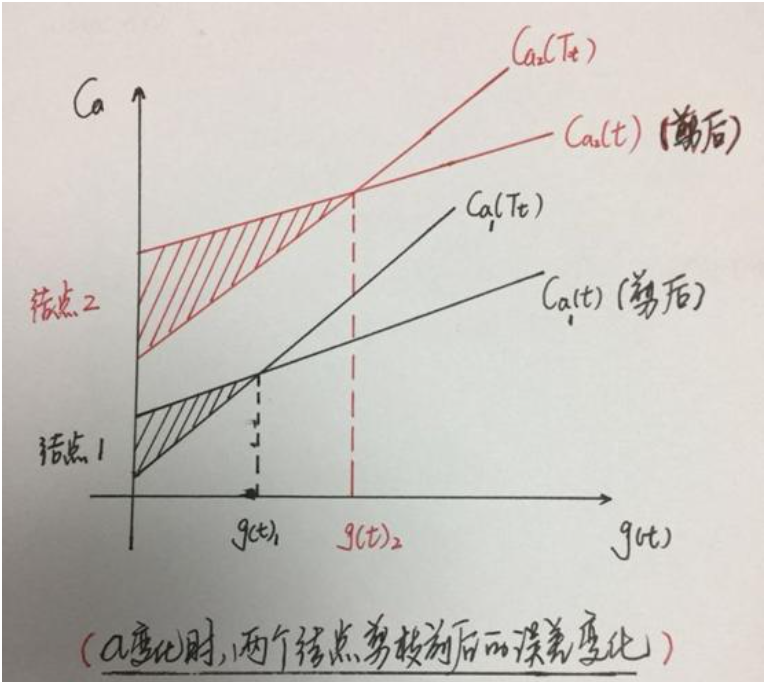


**讨论：**为什么$\alpha$要取最小的$g(t)$呢？  
<br/><center>
<img style="border-radius: 0.3125em;box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);width: 354px;" src="../images/5-1-min-g(t).png"><br><div style="color:orange; border-bottom: 1px solid #d9d9d9;display: inline-block;color: #000;padding: 2px;">图5.1 最小的$g(t)$</div></center>  
&emsp;&emsp;以图中两个点为例，结点1和结点2，$g(t)_2$大于$g(t)_1$，假设在所有结点中$g(t)_1$最小，$g(t)_2$最大，两种选择方法：当选择最大值$g(t)_2$，即结点2进行剪枝，但此时结点1的剪枝前的误差大于剪枝后的误差，即如果不剪枝，误差变大，依次类推，对其它所有的结点的$g(t)$都是如此，从而造成整体的累计误差更大。反之，如果选择最小值$g(t)_1$，即结点1进行剪枝，则其余结点不剪的误差要小于剪枝后的误差，不剪枝为好，且整体的误差最小。从而以最小$g(t)$剪枝获得的子树是该$\alpha$值下的最优子树。

### scikit-learn实例

In [3]:

from sklearn.tree import DecisionTreeClassifier

# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    # print(data)
    return data[:,:2], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train,)
print(clf.score(X_test, y_test))


0.9333333333333333
